In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [3]:
# dataset = MNIST(root='MNIST-DATA/', download=True) 
train_dataset = MNIST(root='MNIST-DATA/', download=False, transform=ToTensor())
test_dataset  = MNIST(root='MNIST-DATA/', train=False, transform=ToTensor())  

C:\Users\David Gamaliel Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([1, 28, 28])


1

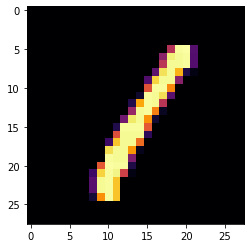

In [4]:
img_tensor, label = train_dataset[3]
print(img_tensor.shape)
plt.imshow(img_tensor[0], cmap='inferno')
label

In [5]:
train_ds, val_ds = random_split(train_dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

images.shape: torch.Size([128, 1, 28, 28])


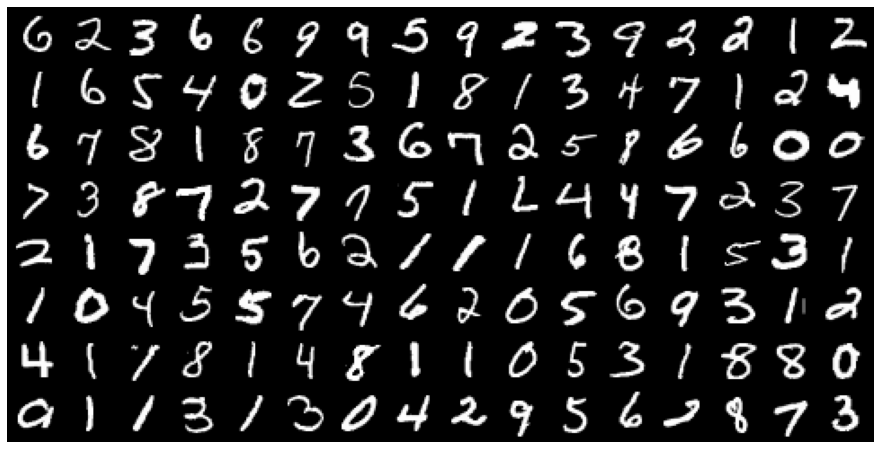

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

In [13]:
class Model(nn.Module):

    def __init__(self, input, hidden, hidden_2, output):
        super(Model, self).__init__()
        self.input_size = input
        # Layer1
        self.linear1 = nn.Linear(input, hidden)
        self.act1 = nn.ReLU()
        # Layer2
        self.linear2 = nn.Linear(hidden, hidden_2)
        self.act2 = nn.Tanh()
        # Layer3
        self.linear3 = nn.Linear(hidden_2, output)

    def forward(self, x):
        x = x.view(-1, self.input_size)  # aqui convertimos la imagen a un vector unidimensional
        out = self.linear1(x)
        out = self.act1(out)
        out = self.linear2(out)
        out = self.act2(out)
        out = self.linear3(out)
        return out
        
    def name(self):
        return "Model"

In [14]:
input_dim  = 28*28  # 784 número de pixeles
hidden_dim = 128    # número de neuronas en las capas ocultas
hidden_di2 = 64    # número de neuronas en las capas ocultas
output_dim = 10     # número de etiquetas

model = Model(input_dim, hidden_dim, hidden_di2, output_dim)

In [15]:
# Usar GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
use_cuda

False

# Optimizer

In [16]:
lr = 1e-2 * 2
opt = torch.optim.SGD(model.parameters(), lr=lr)

# Loss

In [17]:
loss = nn.CrossEntropyLoss()

# Accuracy

In [18]:
def accuracy_fn(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print(model(inputs)[0])
    #plt.figure(figsize=(16,8))
    #plt.axis('off')
    #plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

model

images.shape: torch.Size([128, 1, 28, 28])
tensor([-0.0217, -0.1391, -0.0440,  0.1119, -0.0062,  0.1159, -0.0734, -0.0669,
        -0.0714,  0.1439], grad_fn=<SelectBackward>)


Model(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (act2): Tanh()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:

def fit(train_loader, val_loader, opt, loss_fn, its=10):
    loss_list         = []
    iteration_list    = []
    accuracy_list     = []
    accuracy_list_val = []

    for it in range(its):

        acc, accuracy_val, tot = 0, 0, 0

        for _i, (images, labels) in enumerate(train_loader):

            opt.zero_grad()
            out = model(images)
            loss = loss_fn(out, labels)
            loss.backward()
            opt.step()

            predicted = torch.max(out, dim=1)[1]
            acc += torch.sum(predicted == labels).item()
            tot += labels.numel()


        accuracy = acc/tot
        tot = 0

        iteration_list.append(it)
        loss_list.append(loss.item())
        accuracy_list.append(accuracy)

        for _i, (images, labels) in enumerate(val_loader):
            
            out = model(images)

            predicted = torch.max(out, dim=1)[1]
            accuracy_val += torch.sum(predicted == labels).item()
            tot += labels.numel()
        
        accuracy_val = accuracy_val/tot
        accuracy_list_val.append(accuracy_val)



        print('Epoch: {:02}  Loss: {:.6f}  Accuracy: {:.6f}  Accuracy Val: {:.6f}'.format(it, loss.data, accuracy, accuracy_val))    
    
    return loss_list, iteration_list, accuracy_list, accuracy_list_val


In [21]:
l, it, acc, acc_val = fit(train_loader, val_loader, opt, loss, its=15)

Epoch: 00  Loss: 0.818849  Accuracy: 0.610900  Accuracy Val: 0.789000
Epoch: 01  Loss: 0.538945  Accuracy: 0.835520  Accuracy Val: 0.867500
Epoch: 02  Loss: 0.346059  Accuracy: 0.880960  Accuracy Val: 0.893000
Epoch: 03  Loss: 0.272641  Accuracy: 0.896860  Accuracy Val: 0.902100
Epoch: 04  Loss: 0.337493  Accuracy: 0.905180  Accuracy Val: 0.909900
Epoch: 05  Loss: 0.330093  Accuracy: 0.911620  Accuracy Val: 0.915400
Epoch: 06  Loss: 0.255587  Accuracy: 0.917400  Accuracy Val: 0.920000
Epoch: 07  Loss: 0.296563  Accuracy: 0.921740  Accuracy Val: 0.922500
Epoch: 08  Loss: 0.311834  Accuracy: 0.926220  Accuracy Val: 0.927000
Epoch: 09  Loss: 0.307810  Accuracy: 0.930000  Accuracy Val: 0.930600
Epoch: 10  Loss: 0.181243  Accuracy: 0.934040  Accuracy Val: 0.932900
Epoch: 11  Loss: 0.280981  Accuracy: 0.936940  Accuracy Val: 0.936300
Epoch: 12  Loss: 0.142060  Accuracy: 0.940340  Accuracy Val: 0.937900
Epoch: 13  Loss: 0.094315  Accuracy: 0.942960  Accuracy Val: 0.940200
Epoch: 14  Loss: 0.2

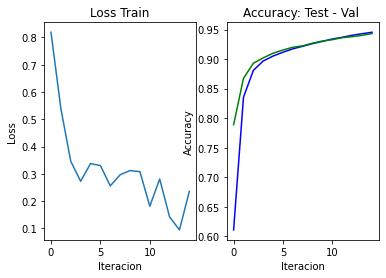

In [22]:
# Loss
plt.subplot(121)
plt.plot(it, l)
plt.xlabel("Iteracion")
plt.ylabel("Loss")
plt.title("Loss Train")

# Accuracy
plt.subplot(122)
plt.plot(it,acc,'b')
plt.plot(it,acc_val, 'g')
plt.xlabel("Iteracion")
plt.ylabel("Accuracy")
plt.title("Accuracy: Test - Val ")

plt.show()

# Predict

In [24]:
# Define test dataset
test_dataset = MNIST(root='MNIST-DATA/', 
                     train=False,
                     transform=ToTensor())

In [30]:
def predict_image(img, model):
    out = model(img)
    _, preds  = torch.max(out, dim=1)
    return preds[0].item()

In [37]:
test_loader = DataLoader(test_dataset, batch_size=25)

images.shape: torch.Size([25, 1, 28, 28])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4])


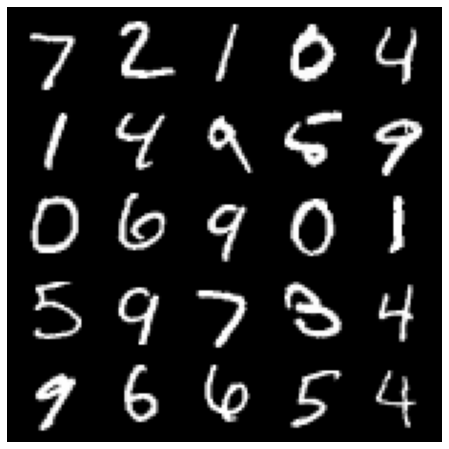

In [58]:
for images, _ in test_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=5).permute((1, 2, 0)), cmap='inferno')
    print( torch.tensor( list(predict_image(_, model) for _ in images)))
    print(_)
    break

#plt.imshow(img[0], cmap='inferno')
#print('Label:', label, ', Predicted:', predict_image(img, model))